In [1]:
import pickle, os
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch

from veloproj import *
from veloproj.model import leastsq_pt
from IPython import display
from matplotlib import pyplot as plt


In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '1e-6', 
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--model-name', 'humanbonemarrow_model.cpt',
                               '--exp-name', 'CohAE_humanbonemarrow',
                               '--device', 'cuda:2',
                               '--nb_g_src', 'X',
                               '--gumbsoft_tau', '1',
                               '--n_raw_gene', '2000',
                               '--n_conn_nb', '30',
                               '--n_nb_newadata', '30',
                               '--aux_weight', '1',
                               '--fit_offset_train', None,
                               '--fit_offset_pred', 'True',
                               '--use_offset_pred', 'True',
                               '--use_gcn', None
                              ])
args                              

Namespace(adata=None, aux_weight=1.0, conv_thred=1e-06, data_dir=None, device='cuda:2', exp_name='CohAE_humanbonemarrow', fit_offset_pred=True, fit_offset_train=False, g_rep_dim=100, gumbsoft_tau=1.0, h_dim=256, k_dim=100, ld_adata='projection.h5', log_interval=100, lr=1e-06, lr_decay=0.9, mask_cluster_list=None, model_name='humanbonemarrow_model.cpt', n_conn_nb=30, n_epochs=20000, n_nb_newadata=30, n_raw_gene=2000, nb_g_src='X', output='./', refit=1, seed=42, sl1_beta=1.0, use_gcn=False, use_norm=False, use_offset_pred=True, use_x=False, v_rg_wt=0.0, vis_key='X_umap', weight_decay=0.0, z_dim=100)

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
# cluster_edges = [("RadialGlia", "RadialGlia2"), 
#  ("RadialGlia2", "ImmAstro"), 
#  ('GlialProg', 'OPC'), 
#  ("Nbl1", "Nbl2"), 
#  ("Nbl2", "CA"),
#  ("Nbl2", "ImmGranule1"),
#  ("ImmGranule1", "ImmGranule2"),
#  ("ImmGranule2", "Granule"),
#  ("CA", "CA1-Sub"),
#  ("CA", "CA2-3-4"),
#  ]
cluster_edges = [("Ery_1", "Ery_2"), ("HSC_1", "HSC_2")]
# cluster_edges = []
k_cluster = "clusters"
# k_cluster = "celltype" 
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
    tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, tensor_v, xyids, device)
    return tensor_s, tensor_u, tensor_x  

Abundance of ['spliced', 'unspliced']: [0.52 0.48]


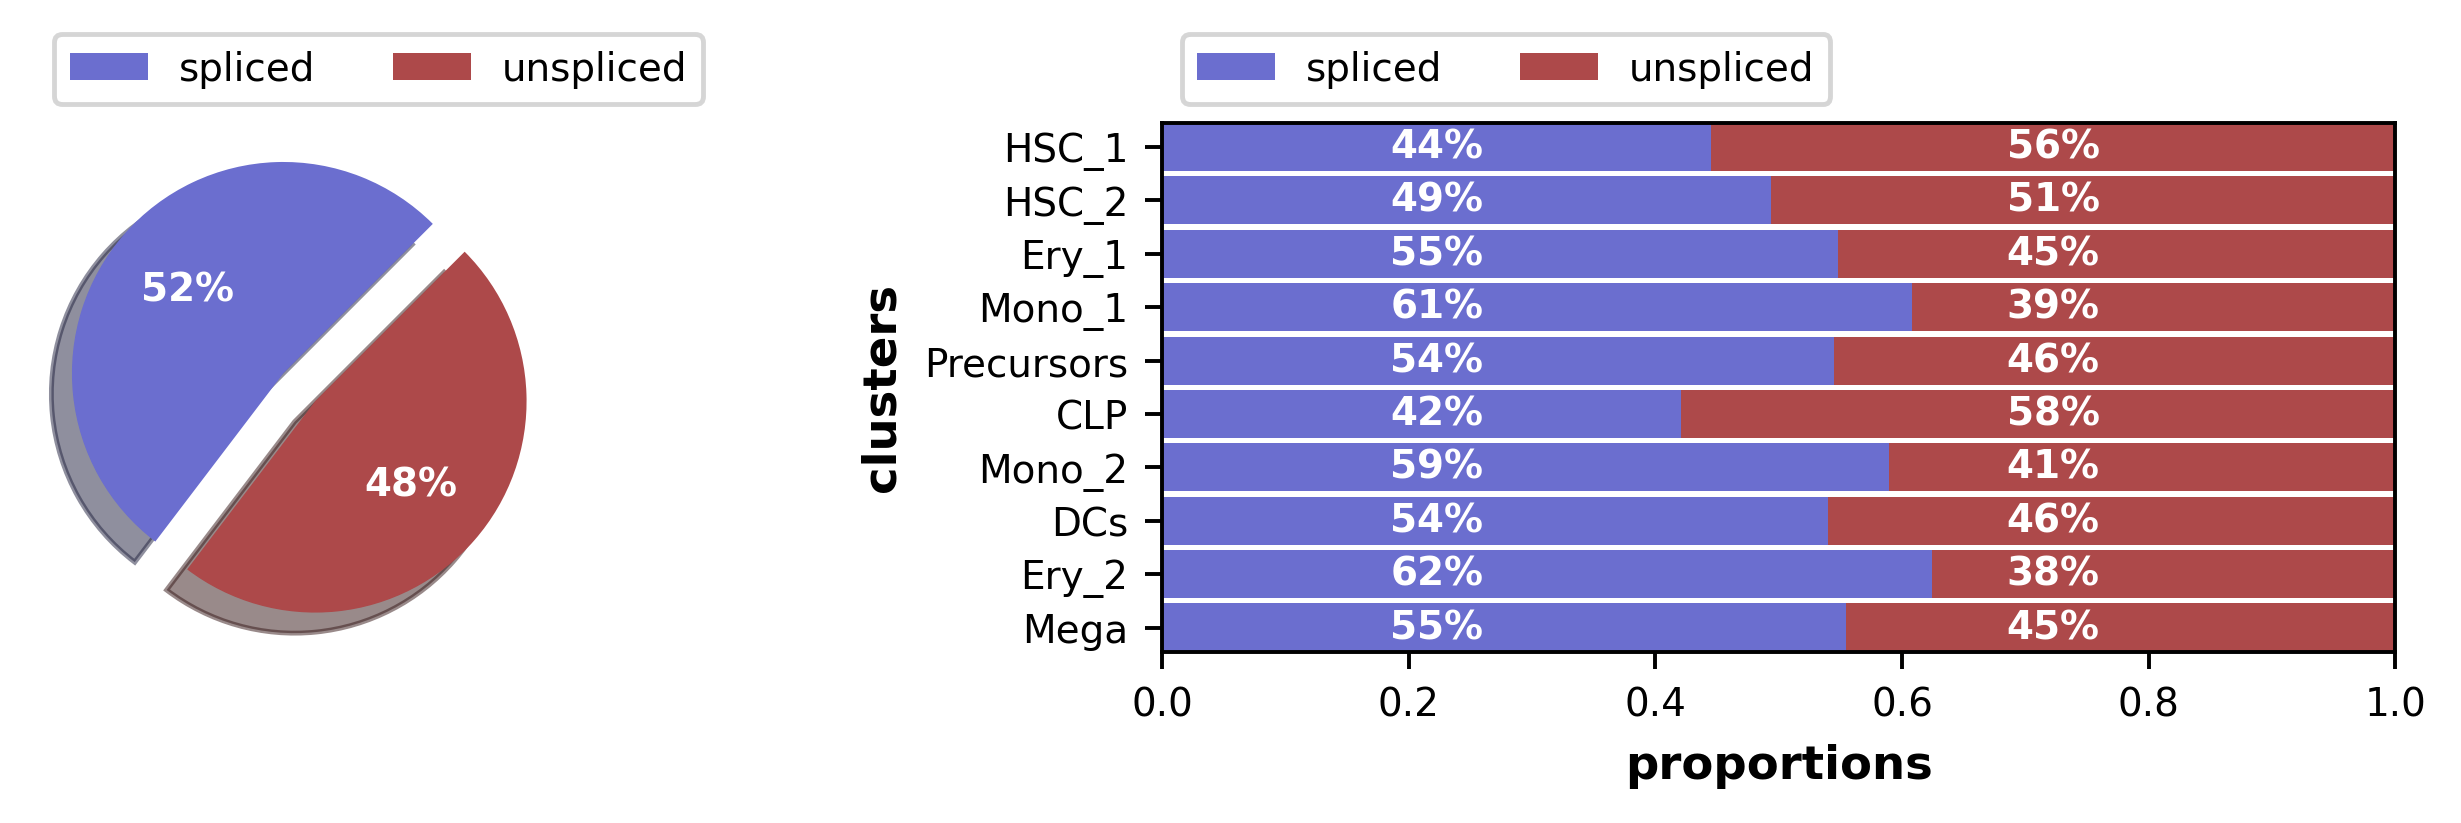

Filtered out 8380 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 5780 × 2000
    obs: 'clusters', 'palantir_pseudotime', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_colors', 'pca', 'neighbors'
    obsm: 'X_tsne', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


In [6]:
# adata = scv.datasets.dentategyrus_lamanno()
adata = scv.datasets.bonemarrow()
# adata = scv.datasets.pbmc68k()
scv.pp.remove_duplicate_cells(adata)
# adata.obsm["X_tsne"][:, 0] *= -1
adata.obsm['X_umap'] = adata.obsm["X_tsne"]
# adata.obsm['X_umap'] = adata.obsm["X_pca"]
scv.utils.show_proportions(adata)
scv.pl.proportions(adata, dpi=350)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.moments(adata)
print(adata)

computing velocities
    finished (0:00:01) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/40 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:14) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:02) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_humanbonemarrao_stc.png


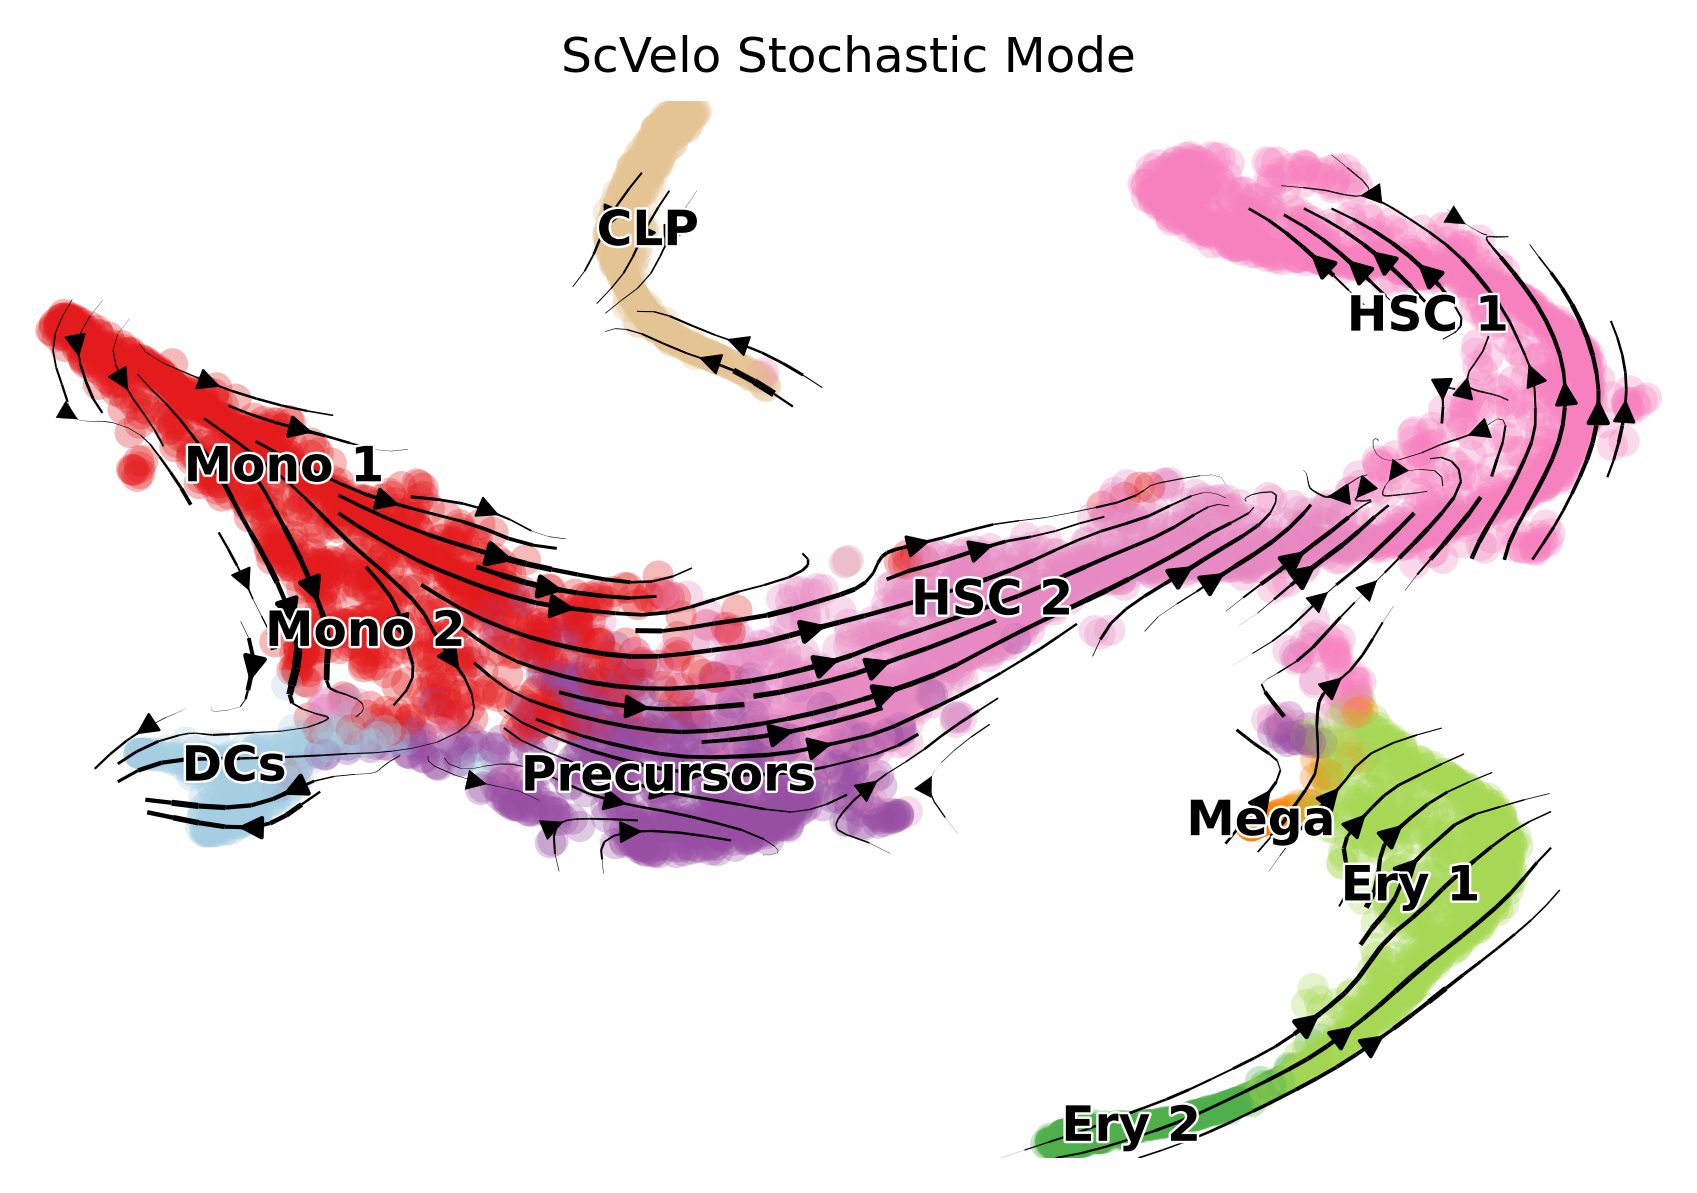

# Cross-Boundary Transition Score (A->B)
{('Ery_1', 'Ery_2'): 0.036592852, ('HSC_1', 'HSC_2'): 0.07029554}
Total Mean: 0.05344419926404953
# Cross-Boundary Velocity Coherence (A->B)
{('Ery_1', 'Ery_2'): 0.9677103, ('HSC_1', 'HSC_2'): 0.83400494}
Total Mean: 0.9008576273918152
# Cross-Boundary Direction Correctness (A->B)
{('Ery_1', 'Ery_2'): -0.861143847304595, ('HSC_1', 'HSC_2'): -0.4896823305395139}
Total Mean: -0.6754130889220544
# In-cluster Coherence
{'CLP': 0.8313895, 'DCs': 0.9291757, 'Ery_1': 0.9454572, 'Ery_2': 0.9773299, 'HSC_1': 0.8359247, 'HSC_2': 0.8923643, 'Mega': 0.95095336, 'Mono_1': 0.91305476, 'Mono_2': 0.9269879, 'Precursors': 0.93350375}
Total Mean: 0.9136141538619995
# In-cluster Confidence
{'CLP': 0.9173560258550723, 'DCs': 0.9089615012552872, 'Ery_1': 0.9254641226841754, 'Ery_2': 0.9444700457015127, 'HSC_1': 0.8502651855003002, 'HSC_2': 0.8846816293955818, 'Mega': 0.8665873144493729, 'Mono_1': 0.9035902946199501, 'Mono_2': 0.9225378250464414, 'Precursors': 0.9203

In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity')
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata,  
                                # legend_loc="right margin", 
                                vkey="stc_velocity", 
                                basis='X_umap', 
                                color=[k_cluster],
                                dpi=350,
                                # arrow_length=5,
                                title='ScVelo Stochastic Mode',
                                smooth=0.5,
                                save="humanbonemarrao_stc.png"
                                )
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity")

computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Train Epoch: 100/20000 	Loss: 3.311918
Train Epoch: 200/20000 	Loss: 3.300150
Train Epoch: 300/20000 	Loss: 3.290283
Train Epoch: 400/20000 	Loss: 3.266134
Train Epoch: 500/20000 	Loss: 3.235880
Train Epoch: 600/20000 	Loss: 3.203348
Train Epoch: 700/20000 	Loss: 3.165531
Train Epoch: 800/20000 	Loss: 3.125987
Train Epoch: 900/20000 	Loss: 3.090496
Train Epoch: 1000/20000 	Loss: 3.063793
Train Epoch: 1100/20000 	Loss: 3.035747
Train Epoch: 1200/20000 	Loss: 3.015457
Train Epoch: 1300/20000 	Loss: 2.997260
Train Epoch: 1400/20000 	Loss: 2.980488
Train Epoch: 1500/20000 	Loss: 2.966226
Train Epoch: 1600/20000 	Loss: 2.947672
Train Epoch: 1700/20000 	Loss: 2.923618
Train Epoch: 1800/20000 	Loss: 2.909174
Train Epoch: 

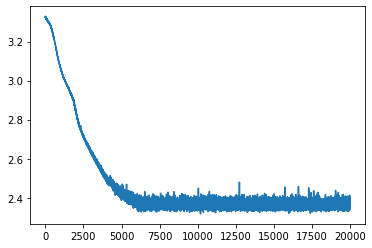

In [8]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph (using 1/40 cores)
    finished (0:00:13) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_humanbonemarrow_pojection.png


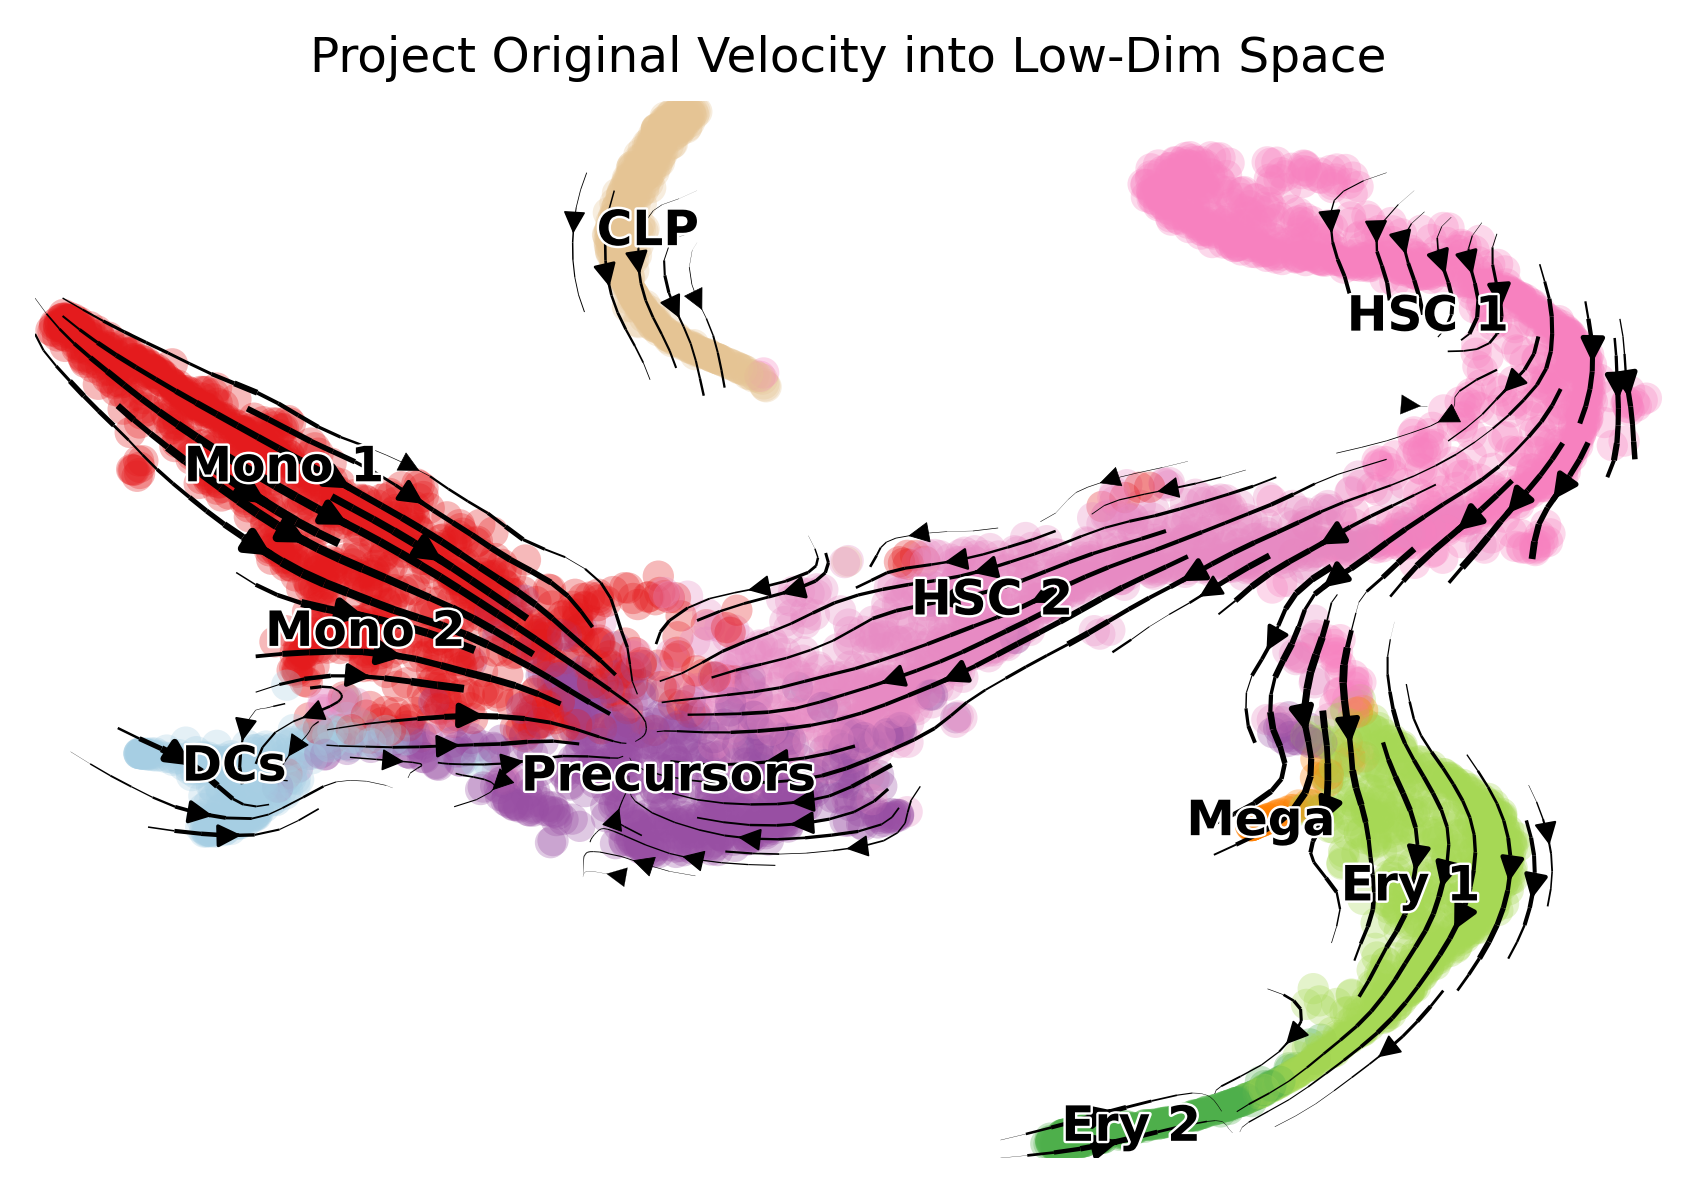

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Ery_1', 'Ery_2'): 0.32750764, ('HSC_1', 'HSC_2'): 0.4874055}
Total Mean: 0.40745657682418823
# Cross-Boundary Velocity Coherence (A->B)
{('Ery_1', 'Ery_2'): 0.69615865, ('HSC_1', 'HSC_2'): 0.945111}
Total Mean: 0.8206348419189453
# Cross-Boundary Direction Correctness (A->B)
{('Ery_1', 'Ery_2'): 0.3229353647987732, ('HSC_1', 'HSC_2'): 0.7034249505297435}
Total Mean: 0.5131801576642584
# In-cluster Coherence
{'CLP': 0.94169587, 'DCs': 0.96035314, 'Ery_1': 0.8603885, 'Ery_2': 0.9035035, 'HSC_1': 0.9626481, 'HSC_2': 0.8901804, 'Mega': 0.8454535, 'Mono_1': 0.9817962, 'Mono_2': 0.96028274, 'Precursors': 0.8495526}
Total Mean: 0.9155853986740112
# In-cluster Confidence
{'CLP': 0.94398245360458, 'DCs': 0.951003221100313, 'Ery_1': 0.8280490650694988, 'Ery_2': 0.8979521261633567, 'HSC_1': 0.949918179387

In [9]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, perc=[5, 95], 
                                 norm=args.use_norm, fit_offset=args.fit_offset_pred, 
                                 use_offset=args.use_offset_pred).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src, n_nb_newadata=args.n_nb_newadata)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, 
                                    # legend_loc='right_margin', 
                                    vkey="new_velocity", basis='X_umap', color=[k_cluster], # arrow_length=4,
                                    title="Project Original Velocity into Low-Dim Space", smooth=0.5,
                                    dpi=350,
                                    save='humanbonemarrow_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
exp(adata, exp_metrics)

In [11]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)